In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx
import networkx as nx
import os
import helper
import random

/home/alok/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/alok/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
class GraphDQN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphDQN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc(x)
        return x 

In [3]:
def load_features_from_files(dataset_folder):
    node_features = {}
    for filename in os.listdir(dataset_folder):
        if filename.endswith('.feat'):
            feat_file = os.path.join(dataset_folder, filename)
            with open(feat_file, 'r') as f:
                for line in f:
                    values = list(map(float, line.strip().split()))
                    node_id = int(values[0])  # Node ID as first value
                    features = values[1:]     # Remaining values are features
                    node_features[node_id] = torch.tensor(features, dtype=torch.float)
    return node_features

In [4]:
def process_edges_files(dataset_folder):
    graph_list = []
    for filename in os.listdir(dataset_folder):
        if filename.endswith(".edges"):
            G = nx.read_edgelist(os.path.join(dataset_folder, filename))
            # Centrality measures for target Q-value assignment
            degree_centrality = nx.degree_centrality(G)
            betweenness_centrality = nx.betweenness_centrality(G)
            pagerank = nx.pagerank(G)
            # Assign target Q-values to nodes
            for node in G.nodes:
                q_value = (
                    0.4 * degree_centrality[node]
                    + 0.3 * betweenness_centrality[node]
                    + 0.3 * pagerank[node]
                )
                G.nodes[node]['target_q_value'] = q_value
            graph_list.append(G)
    return graph_list

In [5]:
def convert_nx_to_torch_geo(nx_graph, node_features, feature_dim=10):
    for node in nx_graph.nodes():
        if node in node_features:
            nx_graph.nodes[node]['feature'] = node_features[node]
        else:
            nx_graph.nodes[node]['feature'] = torch.zeros(feature_dim)
    data = from_networkx(nx_graph)
    data.x = torch.stack([nx_graph.nodes[node]['feature'] for node in nx_graph.nodes()])
    return data

In [6]:
# def convert_nx_to_torch_geo(nx_graph):
#     for node in nx_graph.nodes():
#         if 'feature' not in nx_graph.nodes[node]:
#             nx_graph.nodes[node]['feature'] = torch.rand(10) 
#             print("Hello")
    
#     data = from_networkx(nx_graph)
#     data.x = torch.stack([data.feature[i] for i in range(len(data.feature))])
#     return data

In [7]:
def convert_graphs_to_torch_geo(graph_list, node_features, feature_dim=10):
    torch_geo_data = []
    for G in graph_list:
        data = convert_nx_to_torch_geo(G, node_features, feature_dim)
        target_q_values = [G.nodes[node]['target_q_value'] for node in G.nodes]
        data.y = torch.tensor(target_q_values, dtype=torch.float)
        torch_geo_data.append(data)
    return torch_geo_data

In [8]:
# def train_dqn(model, graph_list, optimizer, criterion, num_episodes):
#     for episode in range(num_episodes):
#         for graph in graph_list:
#             graph_data = convert_nx_to_torch_geo(graph)
#             node_features = graph_data.x
#             edge_index = graph_data.edge_index
            
#             q_values = model(node_features, edge_index)

#             target_q_values = torch.rand(q_values.size())

#             loss = criterion(q_values, target_q_values)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

In [9]:
def train_dqn(model, data_list, num_epochs=100, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(num_epochs):
        total_loss = 0
        for data in data_list:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = F.mse_loss(out.squeeze(), data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(data_list):.4f}")


In [10]:
# def get_most_influential_nodes(model, nx_graph, top_k=5):
#     model.eval()  
#     graph_data = convert_nx_to_torch_geo(nx_graph)
    
#     with torch.no_grad():
#         node_features = graph_data.x
#         edge_index = graph_data.edge_index

#         q_values = model(node_features, edge_index)

#     _, top_nodes = torch.topk(q_values.squeeze(), k=top_k)
    
#     return top_nodes.tolist()

In [11]:
def get_most_influential_nodes(model, nx_graph, node_features, top_k=5):
    model.eval()
    graph_data = convert_nx_to_torch_geo(nx_graph, node_features)
    with torch.no_grad():
        q_values = model(graph_data.x, graph_data.edge_index)
    _, top_indices = torch.topk(q_values.squeeze(), k=top_k)
    node_mapping = list(nx_graph.nodes)
    top_nodes = [node_mapping[i] for i in top_indices.tolist()]
    return top_nodes

In [12]:
dataset_folder = "dataset"
node_features = load_features_from_files(dataset_folder)
graph_list = process_edges_files(dataset_folder)
torch_geo_data = convert_graphs_to_torch_geo(graph_list, node_features, feature_dim=10)

In [13]:
len(graph_list)

10

In [14]:
# graph1 = nx.karate_club_graph()
# graph2 = nx.erdos_renyi_graph(34, 0.05)

# graph_list = [graph1, graph2]

In [15]:
input_dim = 10  # Adjust to match feature dimensions in your dataset
hidden_dim = 32
output_dim = 1
model = GraphDQN(input_dim, hidden_dim, output_dim)

In [16]:
train_dqn(model, torch_geo_data)

Epoch 1/100, Loss: 0.0149
Epoch 2/100, Loss: 0.0127
Epoch 3/100, Loss: 0.0108
Epoch 4/100, Loss: 0.0091
Epoch 5/100, Loss: 0.0076
Epoch 6/100, Loss: 0.0064
Epoch 7/100, Loss: 0.0054
Epoch 8/100, Loss: 0.0045
Epoch 9/100, Loss: 0.0039
Epoch 10/100, Loss: 0.0033
Epoch 11/100, Loss: 0.0029
Epoch 12/100, Loss: 0.0025
Epoch 13/100, Loss: 0.0023
Epoch 14/100, Loss: 0.0021
Epoch 15/100, Loss: 0.0019
Epoch 16/100, Loss: 0.0018
Epoch 17/100, Loss: 0.0017
Epoch 18/100, Loss: 0.0017
Epoch 19/100, Loss: 0.0016
Epoch 20/100, Loss: 0.0016
Epoch 21/100, Loss: 0.0016
Epoch 22/100, Loss: 0.0015
Epoch 23/100, Loss: 0.0015
Epoch 24/100, Loss: 0.0015
Epoch 25/100, Loss: 0.0015
Epoch 26/100, Loss: 0.0015
Epoch 27/100, Loss: 0.0015
Epoch 28/100, Loss: 0.0015
Epoch 29/100, Loss: 0.0015
Epoch 30/100, Loss: 0.0015
Epoch 31/100, Loss: 0.0015
Epoch 32/100, Loss: 0.0015
Epoch 33/100, Loss: 0.0015
Epoch 34/100, Loss: 0.0015
Epoch 35/100, Loss: 0.0015
Epoch 36/100, Loss: 0.0015
Epoch 37/100, Loss: 0.0015
Epoch 38/1

In [17]:
top_nodes = get_most_influential_nodes(model, graph_list[0], node_features, top_k=5)
print("Most influential nodes:", top_nodes)

Most influential nodes: ['3905', '3750', '3568', '3825', '3549']


## Saving model

In [18]:
torch.save(model.state_dict(), 'graph_dqn_model.pth')

---

---

## Testing with a new graph

In [19]:
# Specify dataset folder
dataset_folder = "./"

# Load features from files in the dataset folder
node_features = load_features_from_files(dataset_folder)

# Specify the graph file
graphname = "12831.edges"
test_graph_path = os.path.join(dataset_folder, graphname)
test_graph = helper.read_graph(test_graph_path)

# Get the circle file for node color assignment
circle_filename = graphname.split(".")[0]
circle_file_path = os.path.join(dataset_folder, f"{circle_filename}.circles")
test_graph_color = helper.assign_colors_to_nodes(test_graph, circle_file_path)

In [20]:
# Get top 5 influential nodes
top_nodes = get_most_influential_nodes(model, test_graph_color, node_features, top_k=5)

print("Top 5 Influential Nodes:", top_nodes)

Top 5 Influential Nodes: [8866342, 19327052, 15302100, 9863222, 22588327]


In [21]:
# [8866342, 19327052, 15302100, 9863222, 22588327]
# [398874773, 652193, 18498878, 14749606, 14305022]

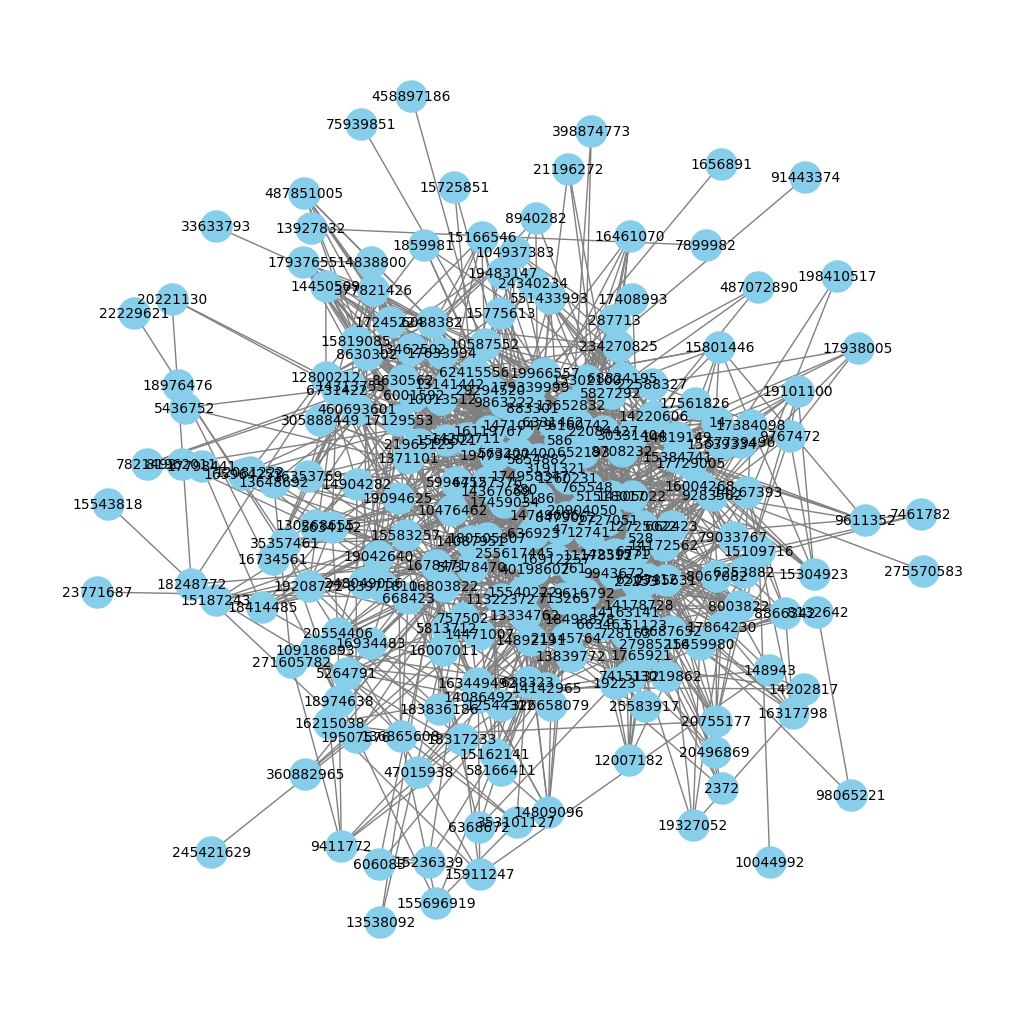

In [22]:
helper.display_graph(test_graph)

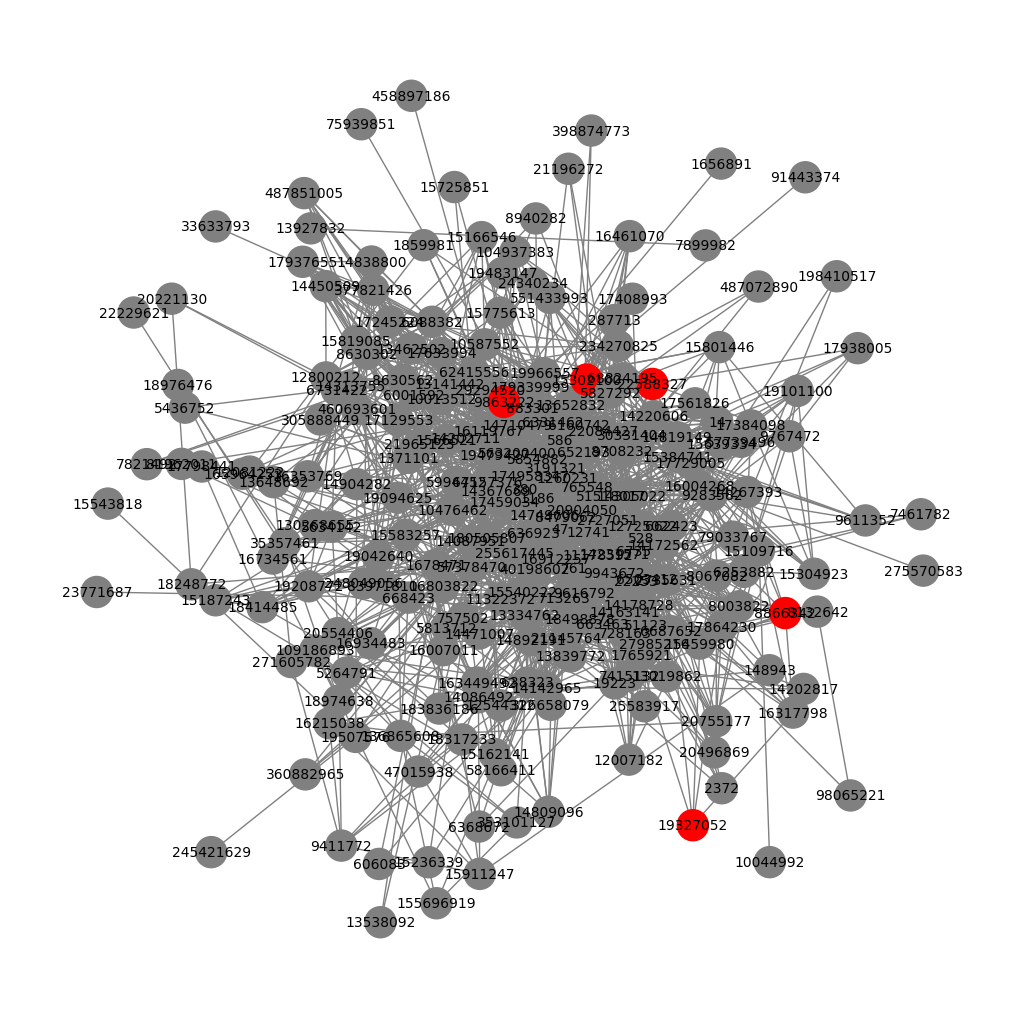

In [23]:
outputGraph = helper.color_specific_nodes_red(test_graph, top_nodes)
helper.display_colored_graph(outputGraph)

In [24]:
# coloured_graph = helper.color_specific_nodes_red(test_graph, top_nodes)
# helper.display_colored_graph(colored_graph)

---

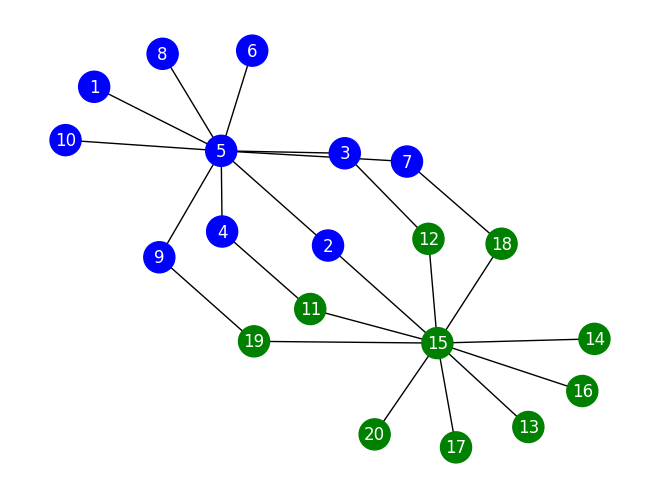

In [50]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
# Create a graph
G = nx.Graph()

# Add nodes 1 to 20
G.add_nodes_from(range(1, 21))

# Add edges for node 5
edges_5 = [(5, i) for i in [1, 2, 3, 4, 6, 7, 8, 9, 10]]
G.add_edges_from(edges_5)

# Add edges for node 15
edges_15 = [(15, i) for i in [11, 12, 13, 14, 16, 17, 18, 19, 20]]
G.add_edges_from(edges_15)

# Add some connections between the two sub-networks
cross_edges = [(3, 12), (7, 18), (2, 15), (9, 19), (4, 11)]  # Sample cross-connections
G.add_edges_from(cross_edges)

# Color nodes: first 10 nodes blue, next 10 nodes green
node_colors = ['blue' if node <= 10 else 'green' for node in G.nodes]

# Draw the graph with color
pos = nx.spring_layout(G)  # Positioning the nodes
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=500, font_color='white')
plt.show()

Top 2 Influential Nodes: [5, 15]


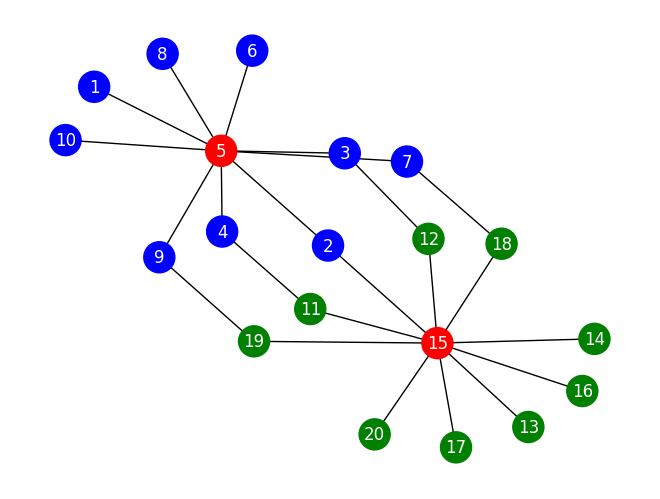

In [51]:
# Generate synthetic node features for testing
node_features = {node: torch.rand(10) for node in G.nodes}  # Assuming 10 features per node

# Find top influential nodes
test_graph = G  # This is the graph created above
top_nodes = get_most_influential_nodes(model, test_graph, node_features, top_k=2)
print("Top 2 Influential Nodes:", top_nodes)

# Update color of top influential nodes to red for visualization
outputGraph = test_graph.copy()
for node in top_nodes:
    outputGraph.nodes[node]['color'] = 'red'

# Visualize the updated graph
node_colors = [outputGraph.nodes[node].get('color', 'blue' if node <= 10 else 'green') for node in outputGraph.nodes]
nx.draw(outputGraph, pos, with_labels=True, node_color=node_colors, node_size=500, font_color='white')
plt.show()

---

For accuracy measure refer the https://chatgpt.com/share/6730c9ee-7d58-8008-aa49-306c925277c0

Need some correction

---

In [54]:
def create_connected_graph(num_nodes=100):
    G = nx.Graph()
    
    # Add nodes from 1 to num_nodes
    G.add_nodes_from(range(1, num_nodes + 1))
    
    # Choose main nodes in each cluster
    main_node_1 = 5
    main_node_2 = 15
    
    # Add edges for the main nodes with random connections within clusters
    cluster_1_nodes = random.sample(range(1, num_nodes // 2 + 1), k=random.randint(20, 30))
    cluster_2_nodes = random.sample(range(num_nodes // 2 + 1, num_nodes + 1), k=random.randint(20, 30))
    
    edges_1 = [(main_node_1, i) for i in cluster_1_nodes if i != main_node_1]
    edges_2 = [(main_node_2, i) for i in cluster_2_nodes if i != main_node_2]
    
    G.add_edges_from(edges_1 + edges_2)
    
    # Add random cross-connections between the two clusters
    cross_edges = [(random.choice(cluster_1_nodes), random.choice(cluster_2_nodes)) for _ in range(10)]
    G.add_edges_from(cross_edges)
    
    # Ensure the graph is connected
    if not nx.is_connected(G):
        # Find all disconnected components and connect them
        components = list(nx.connected_components(G))
        for i in range(1, len(components)):
            # Pick one node from each disconnected component and connect them
            node_from_comp1 = random.choice(list(components[i - 1]))
            node_from_comp2 = random.choice(list(components[i]))
            G.add_edge(node_from_comp1, node_from_comp2)
    
    return G

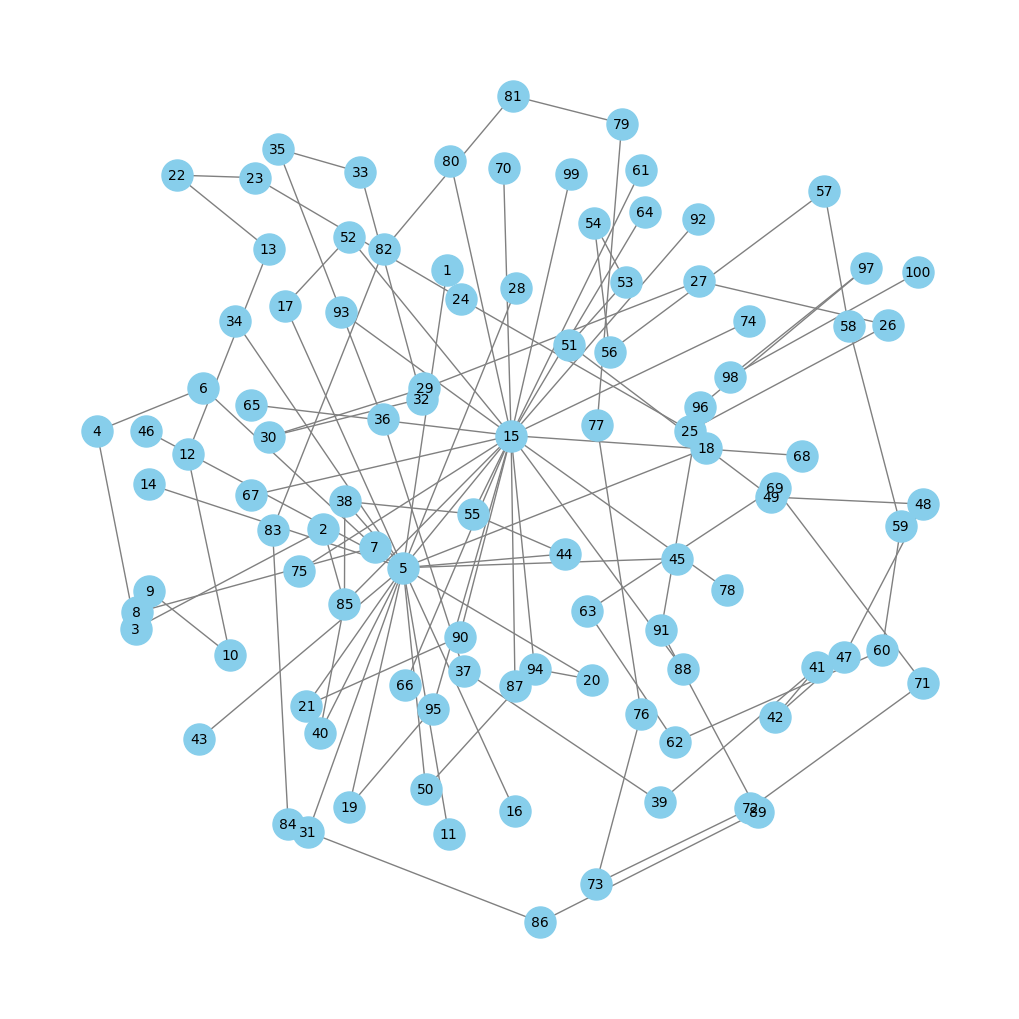

Top 5 Influential Nodes: [5, 15, 63, 62, 69]


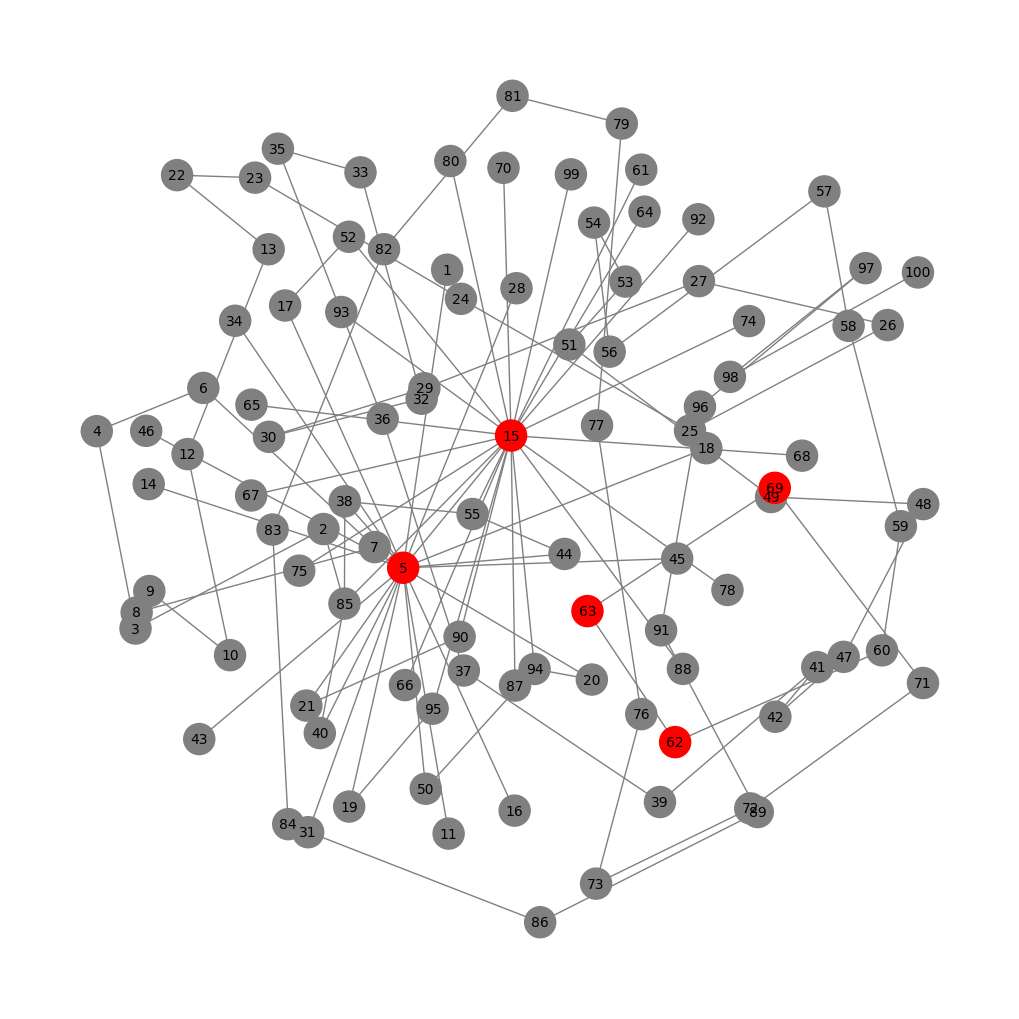

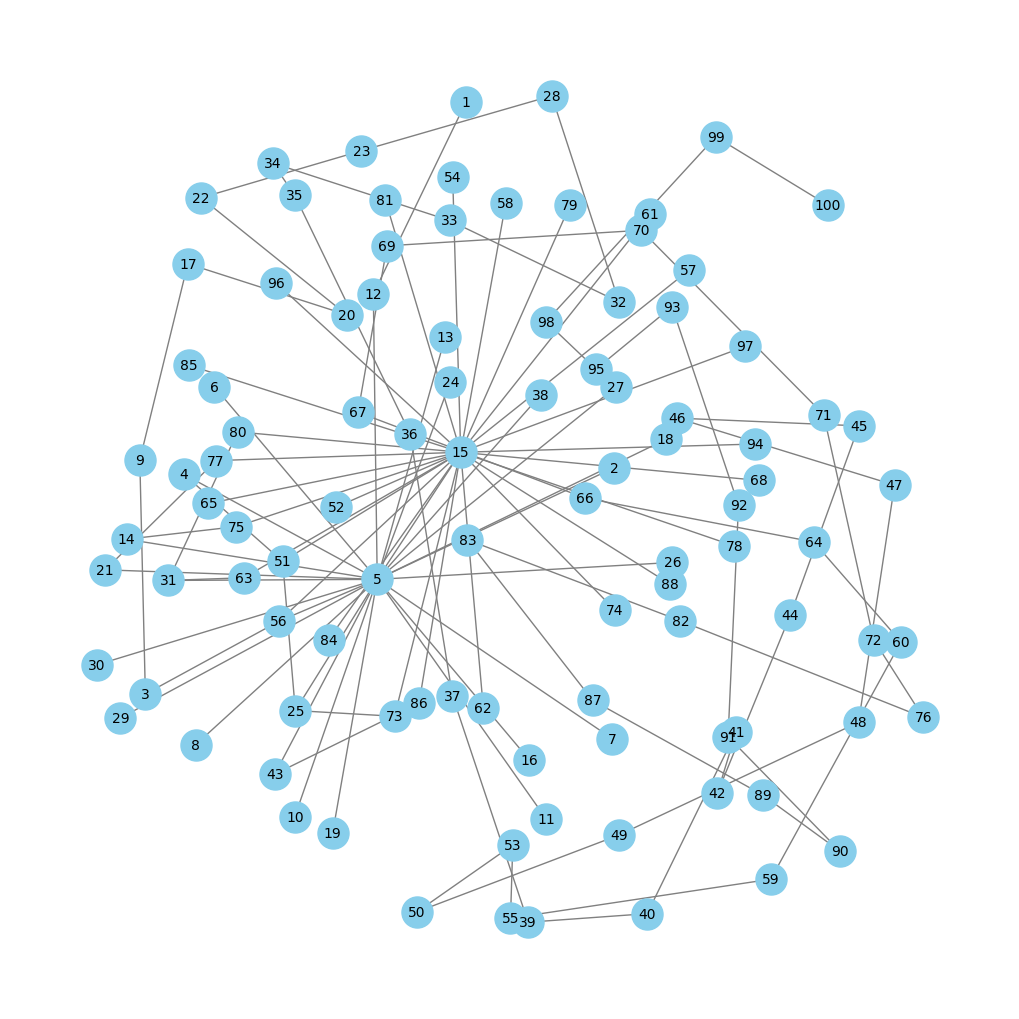

Top 5 Influential Nodes: [5, 15, 99, 66, 100]


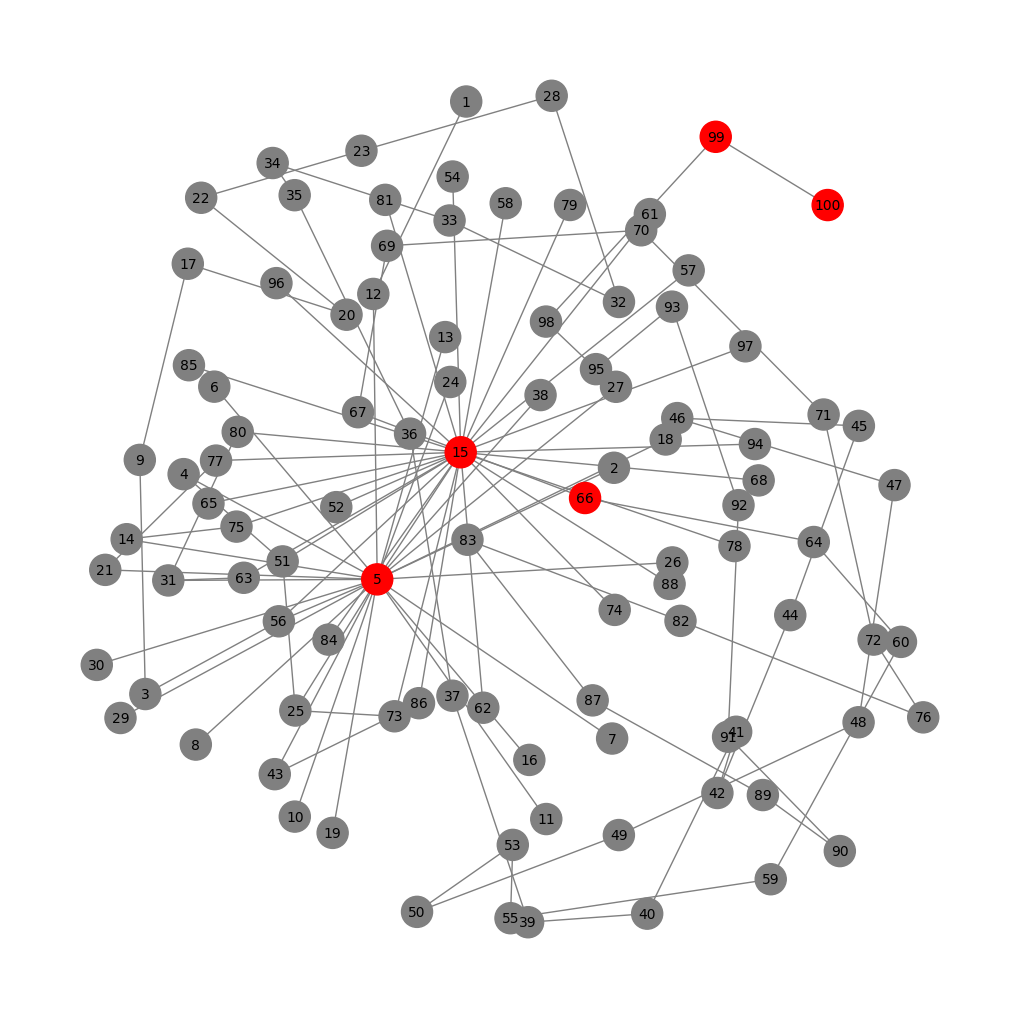

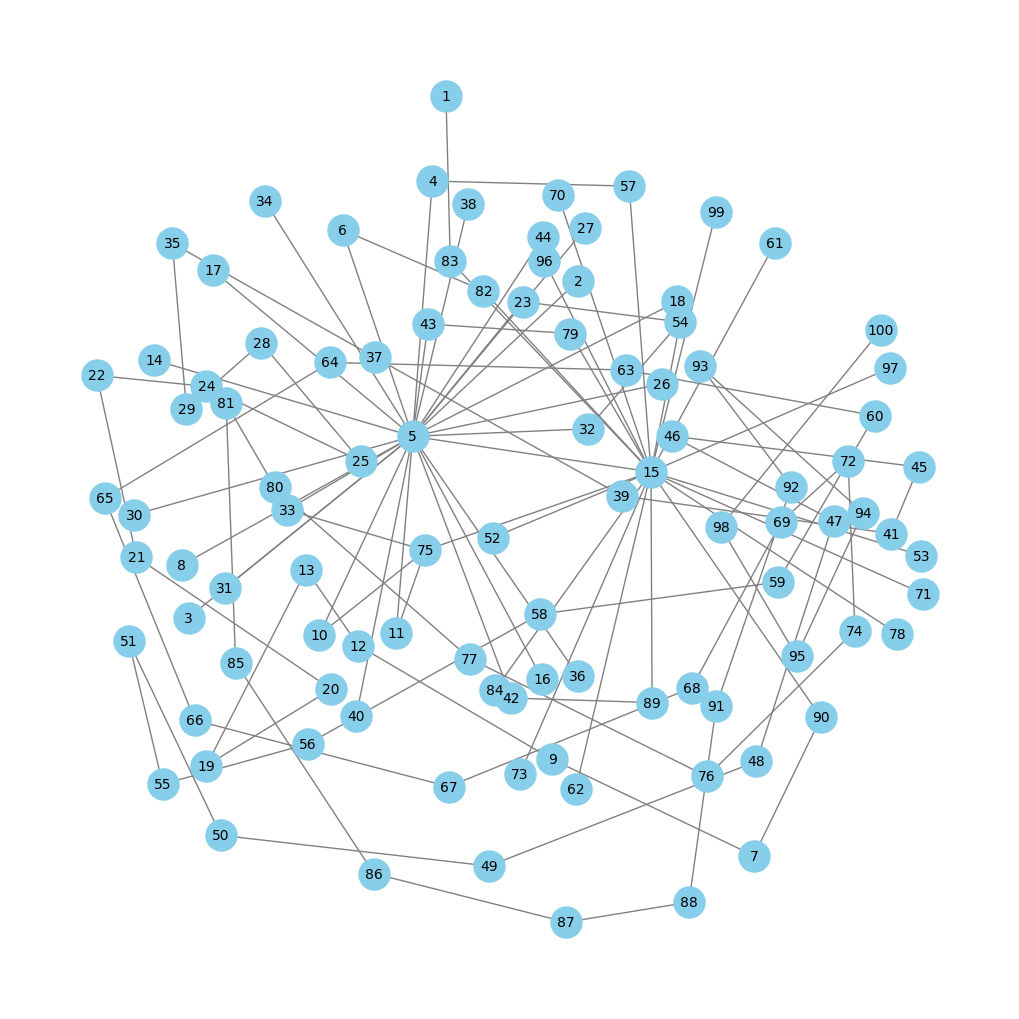

Top 5 Influential Nodes: [15, 5, 50, 55, 49]


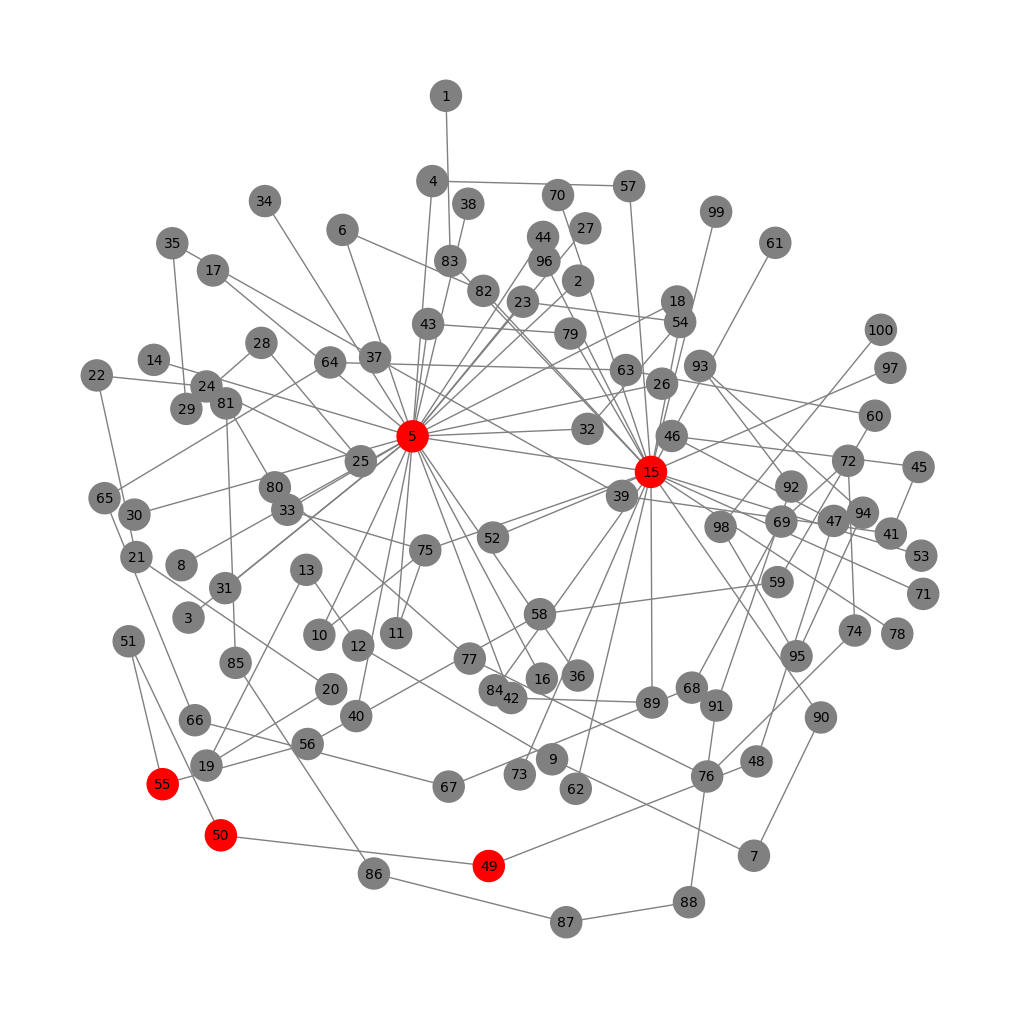

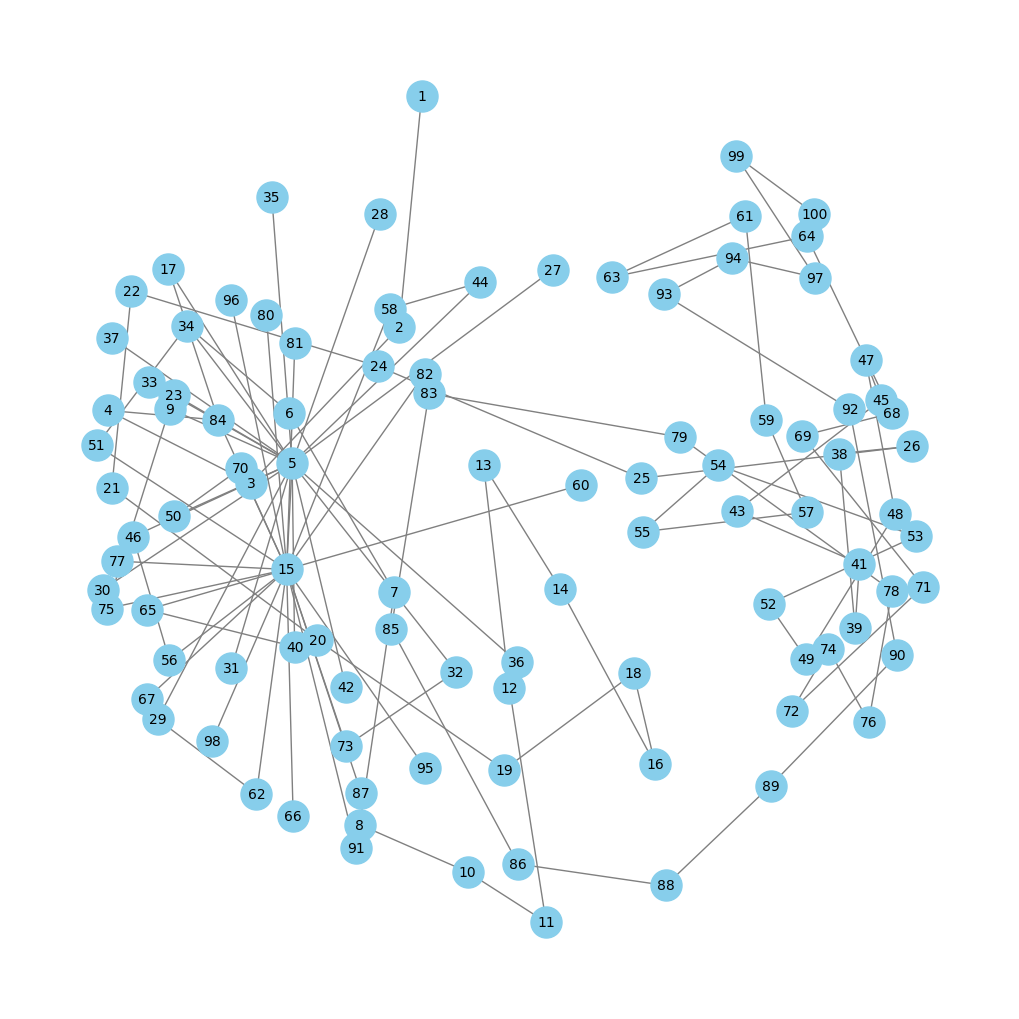

Top 5 Influential Nodes: [15, 5, 94, 93, 92]


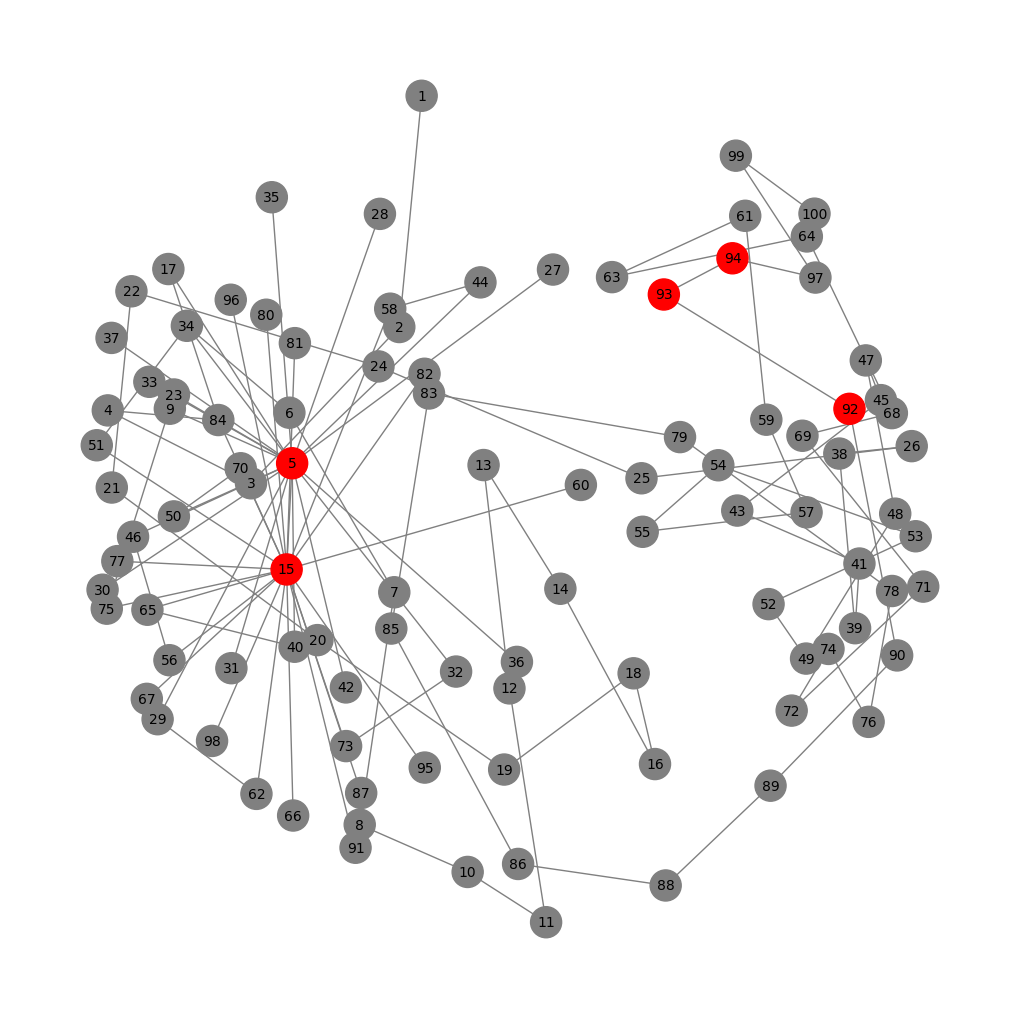

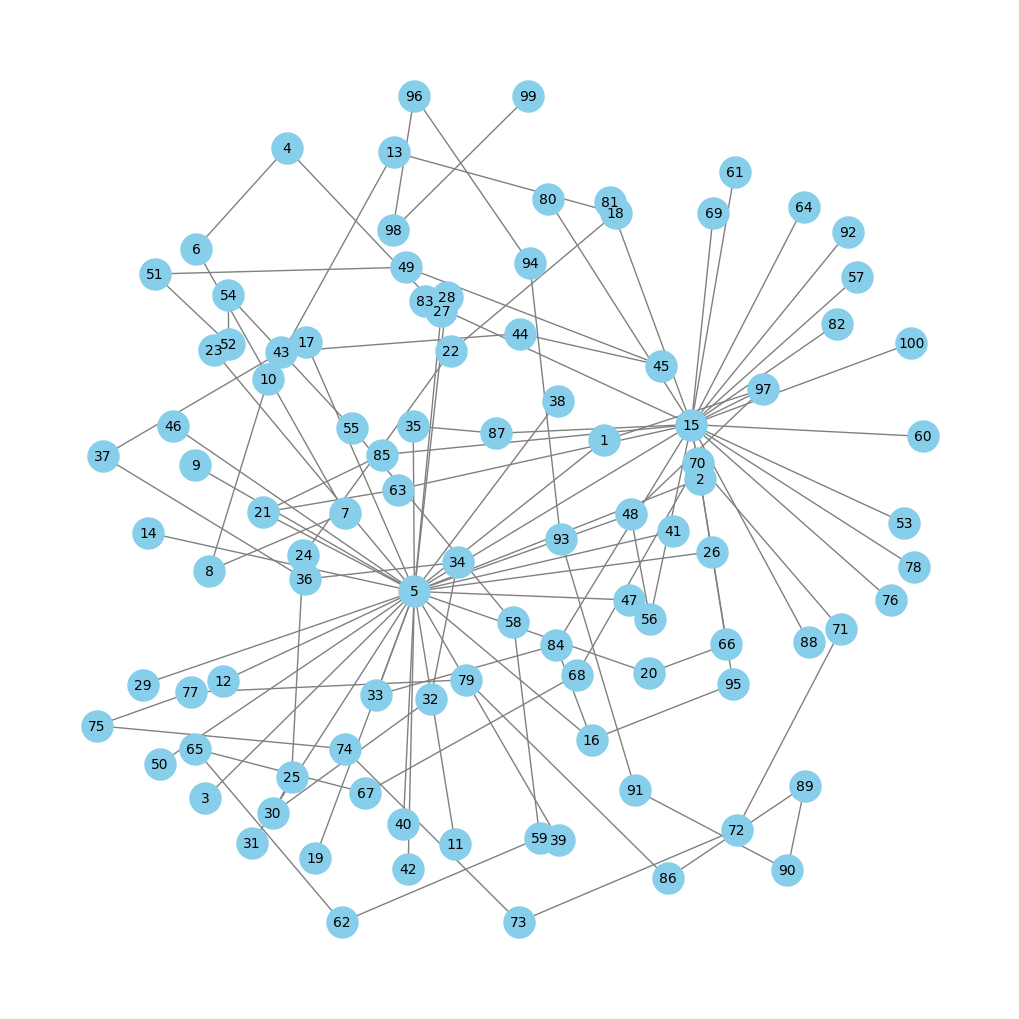

Top 5 Influential Nodes: [90, 5, 91, 15, 89]


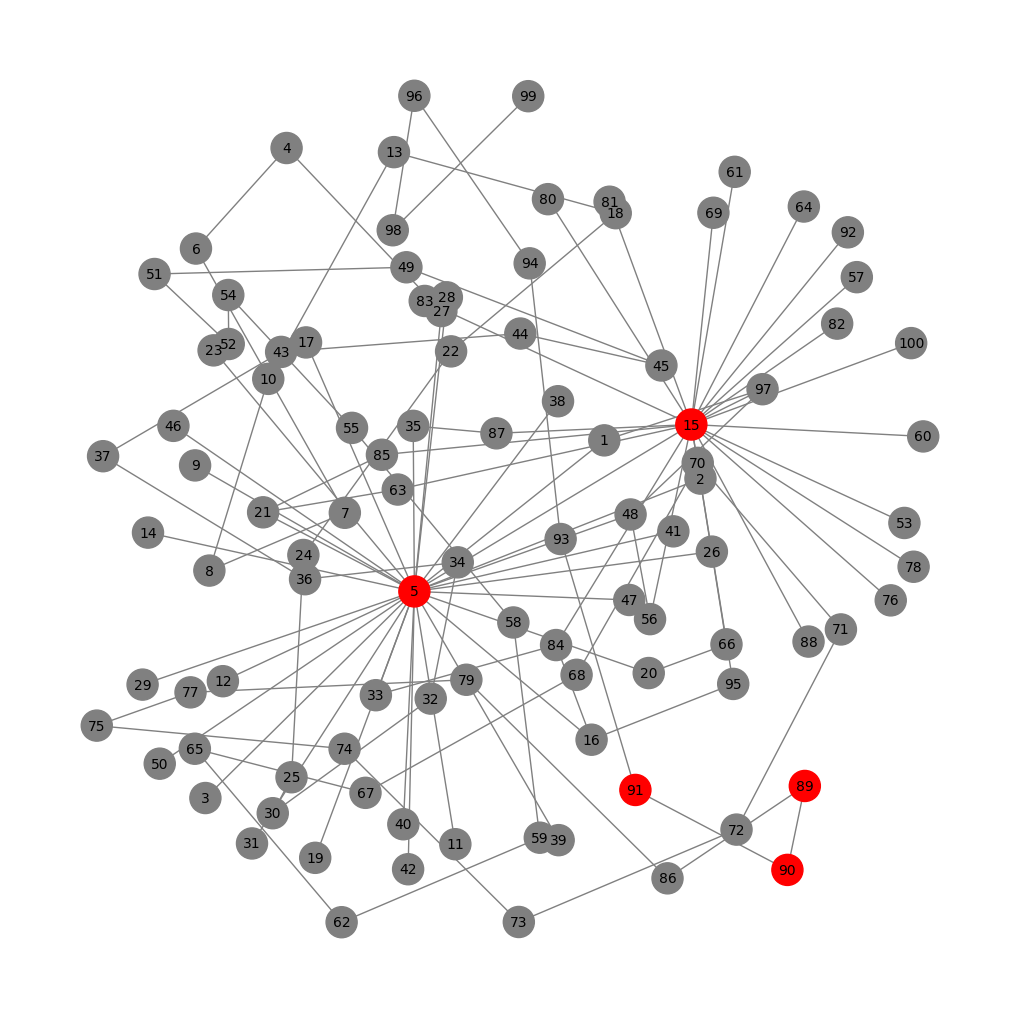

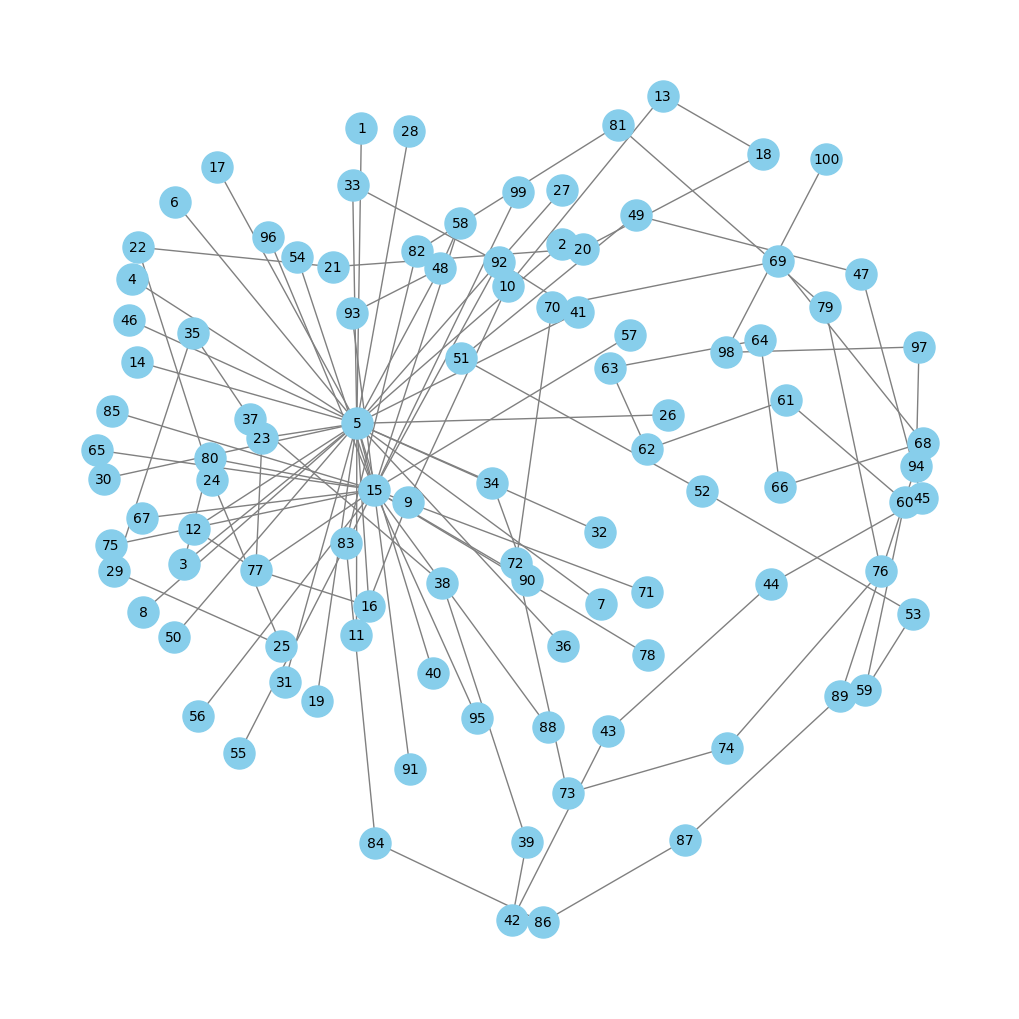

Top 5 Influential Nodes: [5, 15, 69, 70, 44]


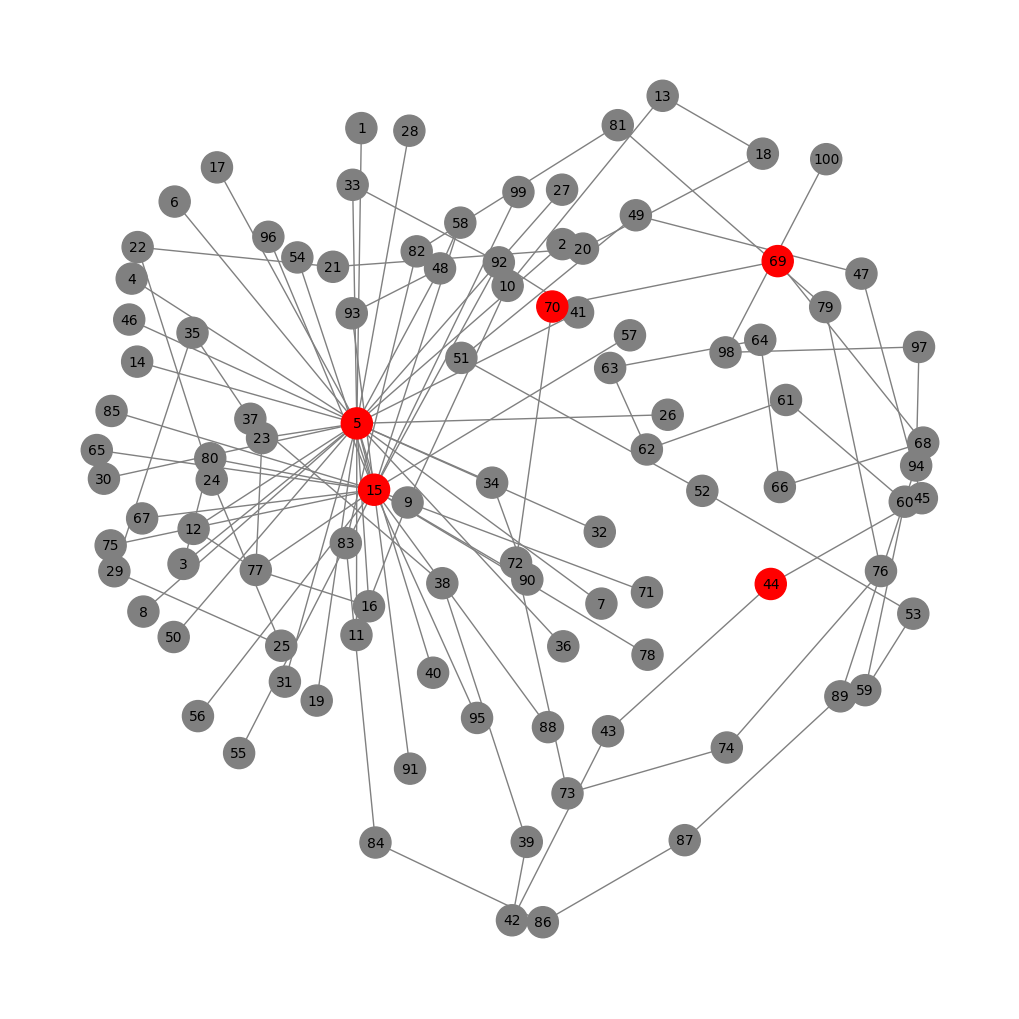

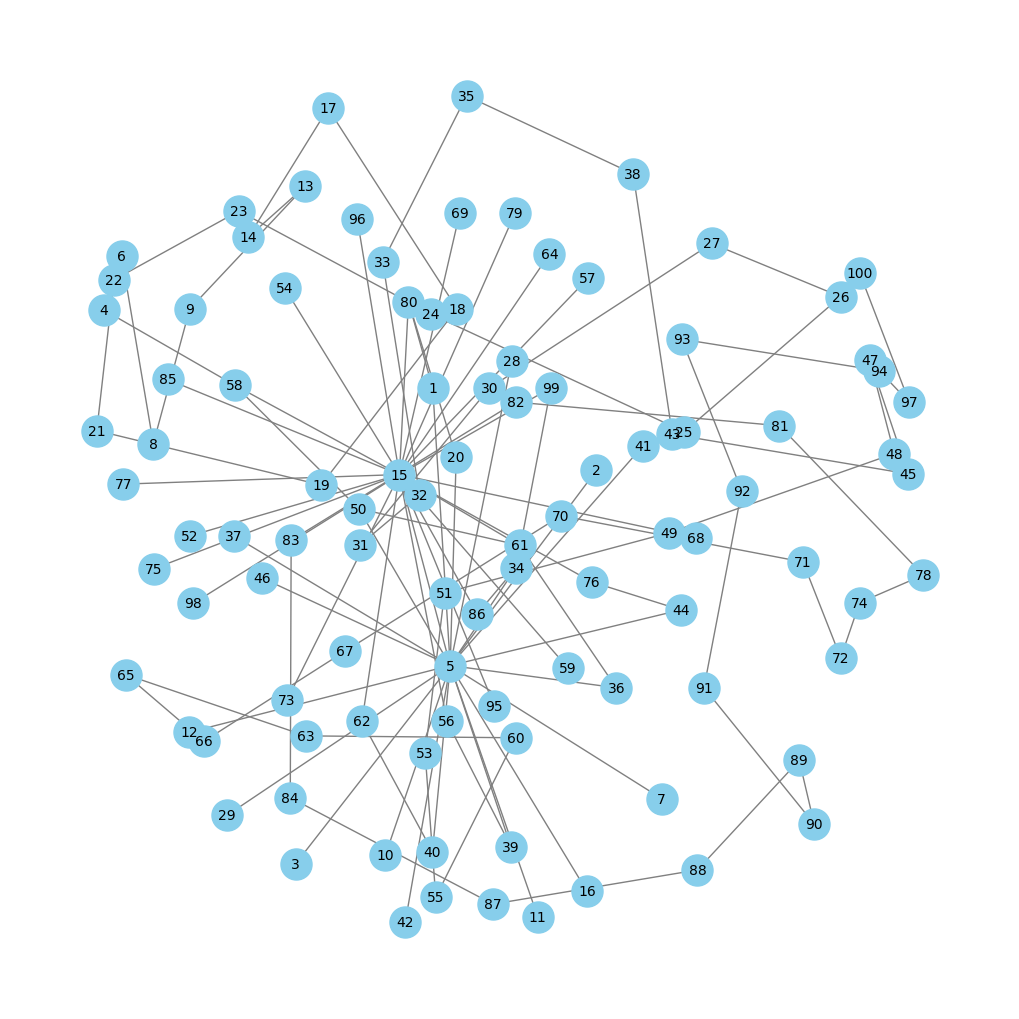

Top 5 Influential Nodes: [5, 15, 24, 25, 97]


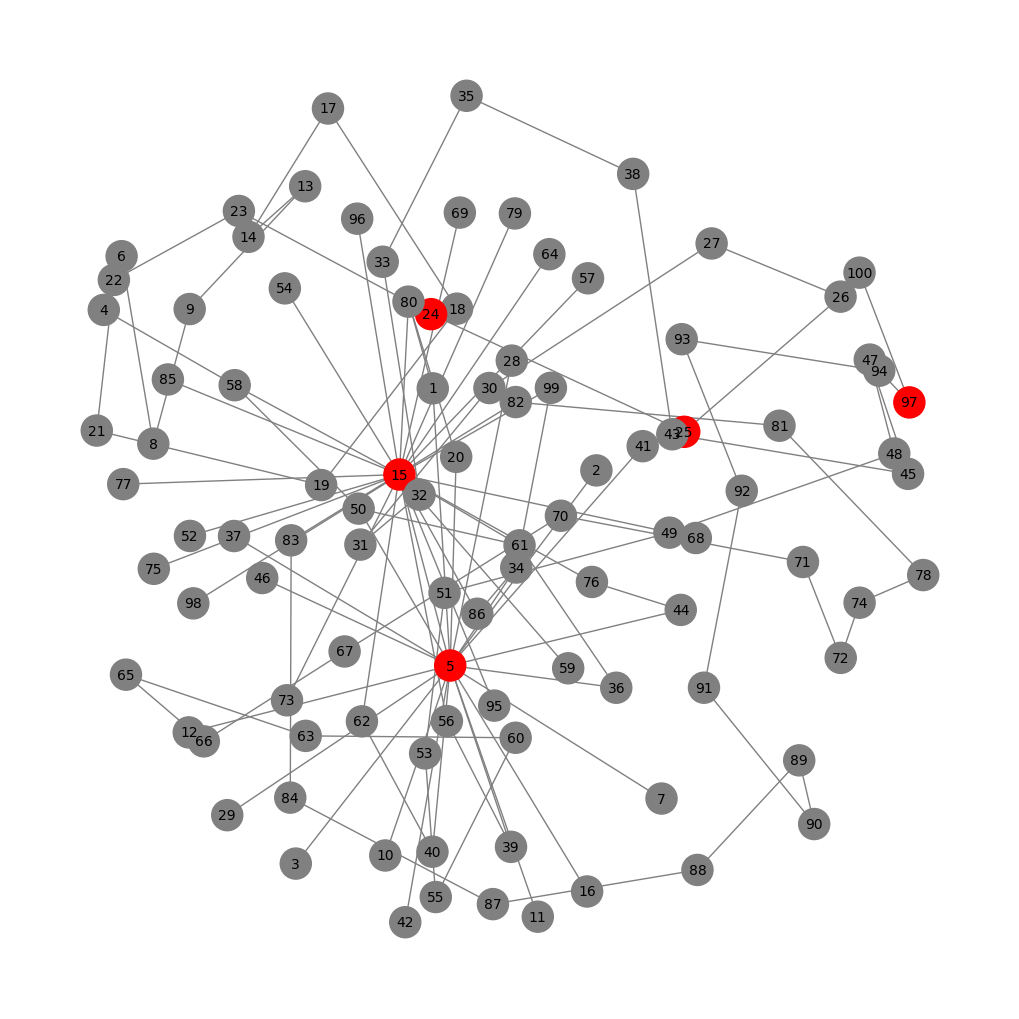

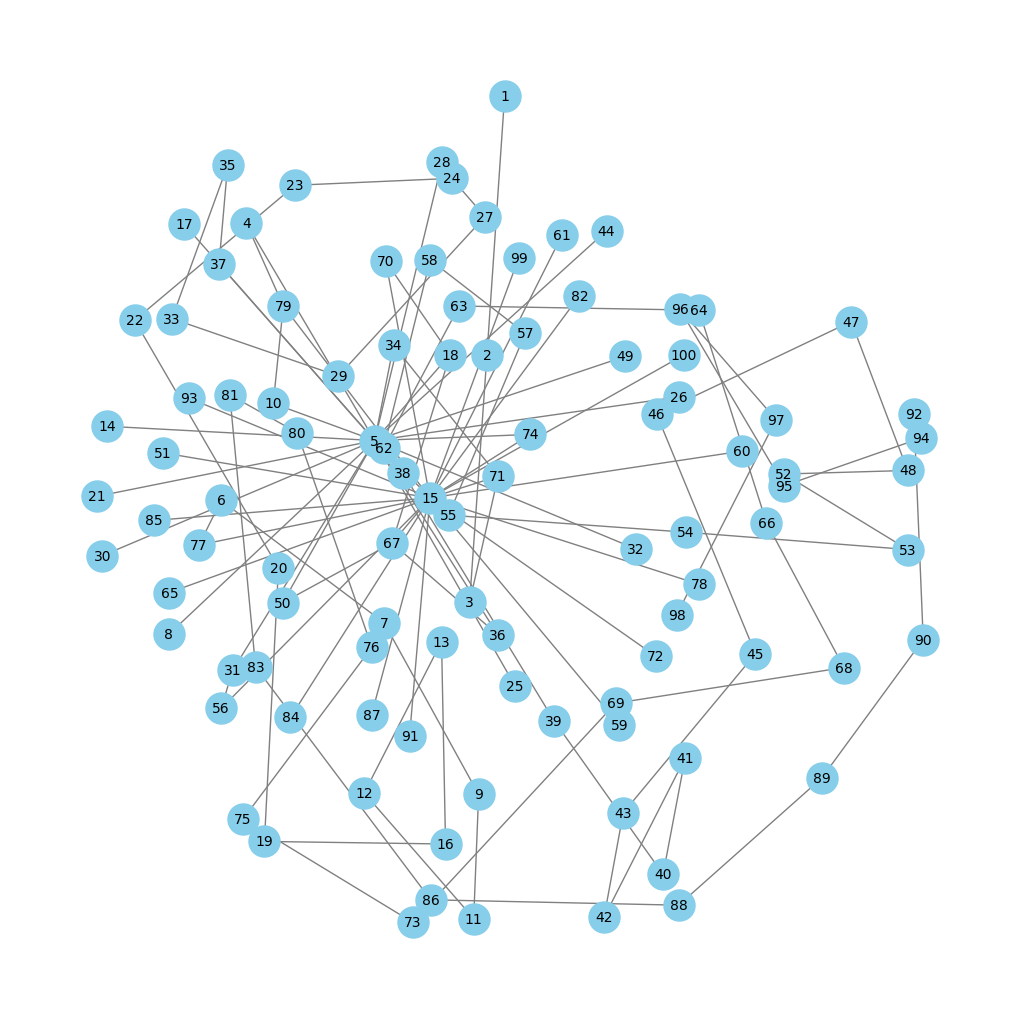

Top 5 Influential Nodes: [52, 53, 57, 58, 37]


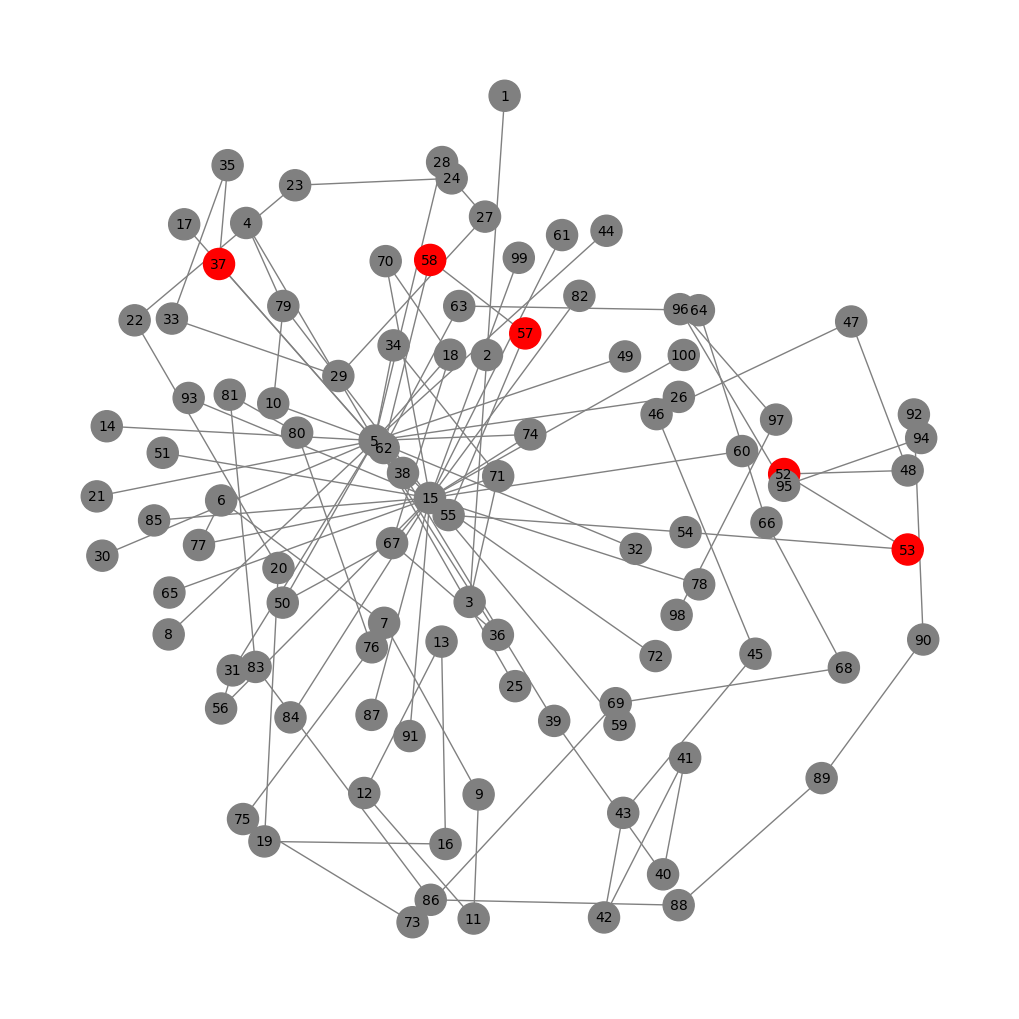

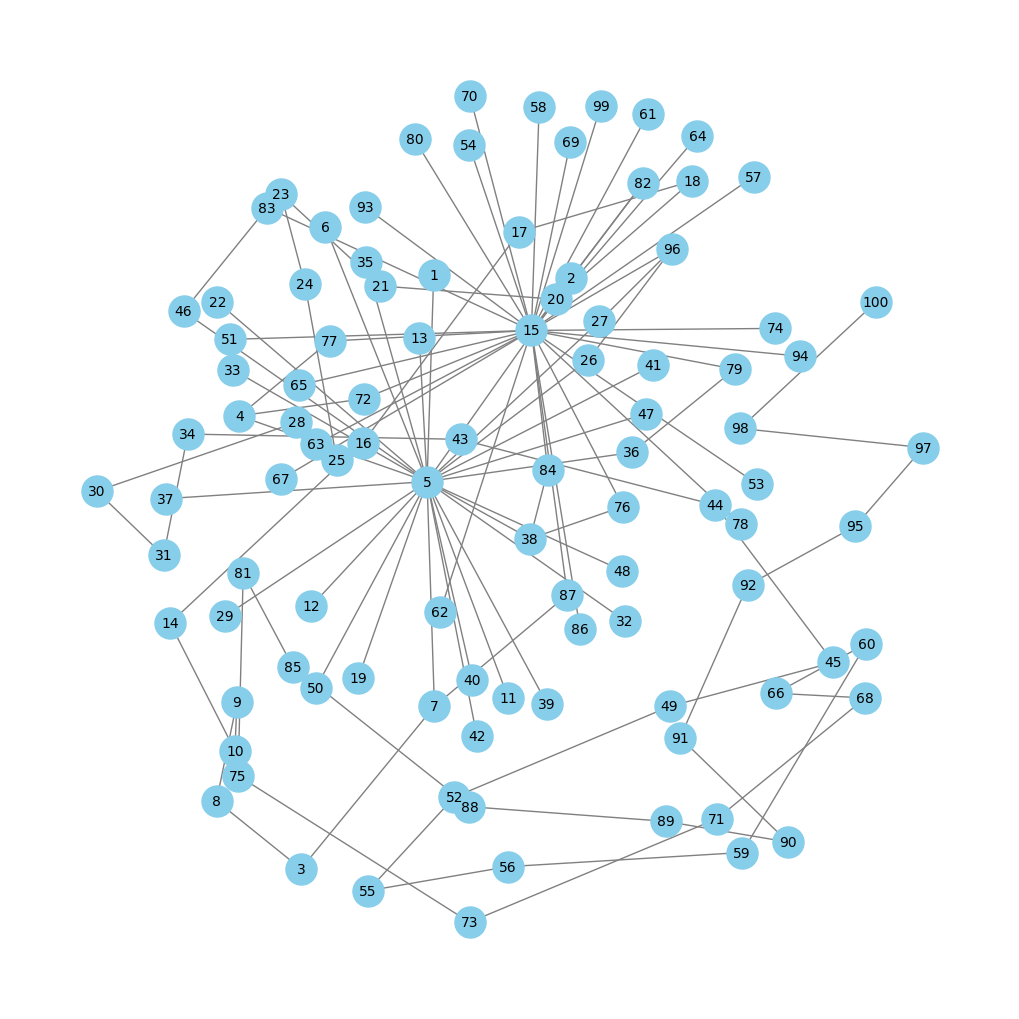

Top 5 Influential Nodes: [5, 15, 49, 52, 96]


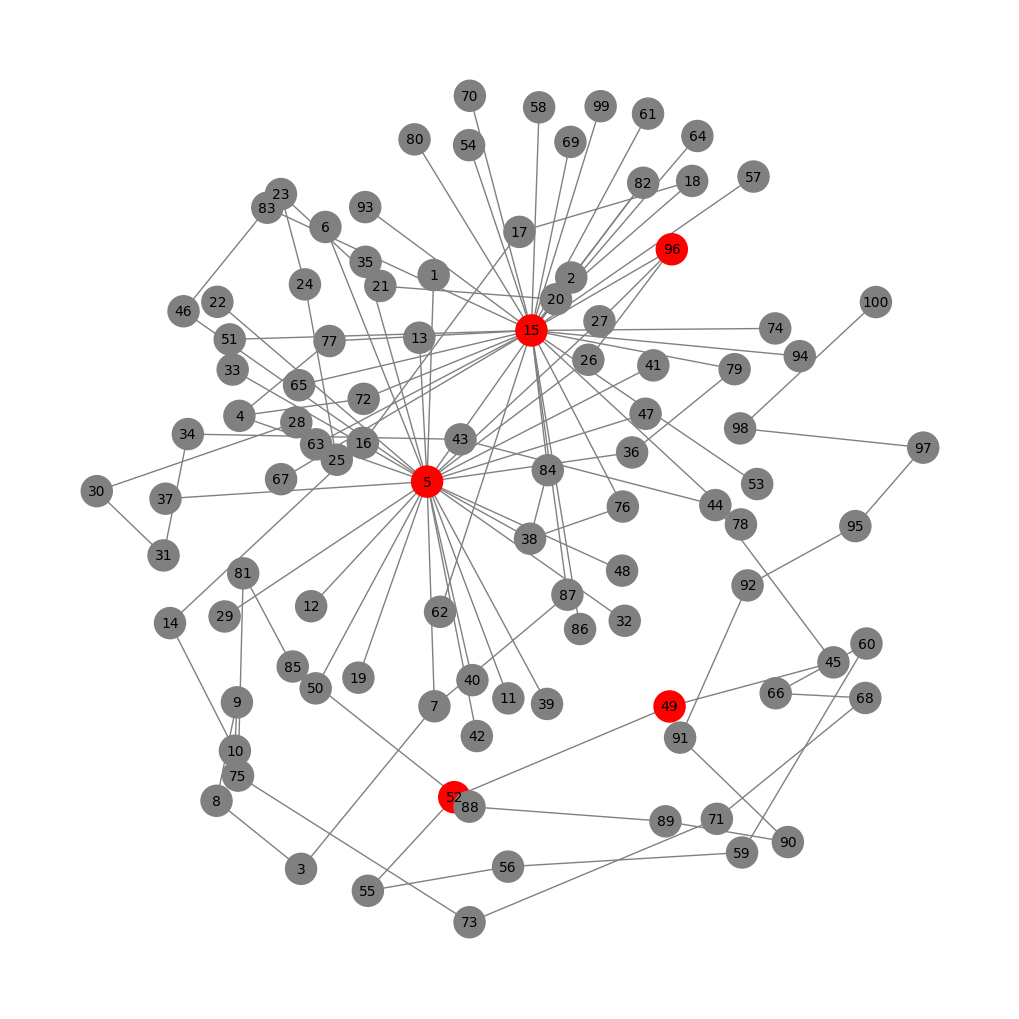

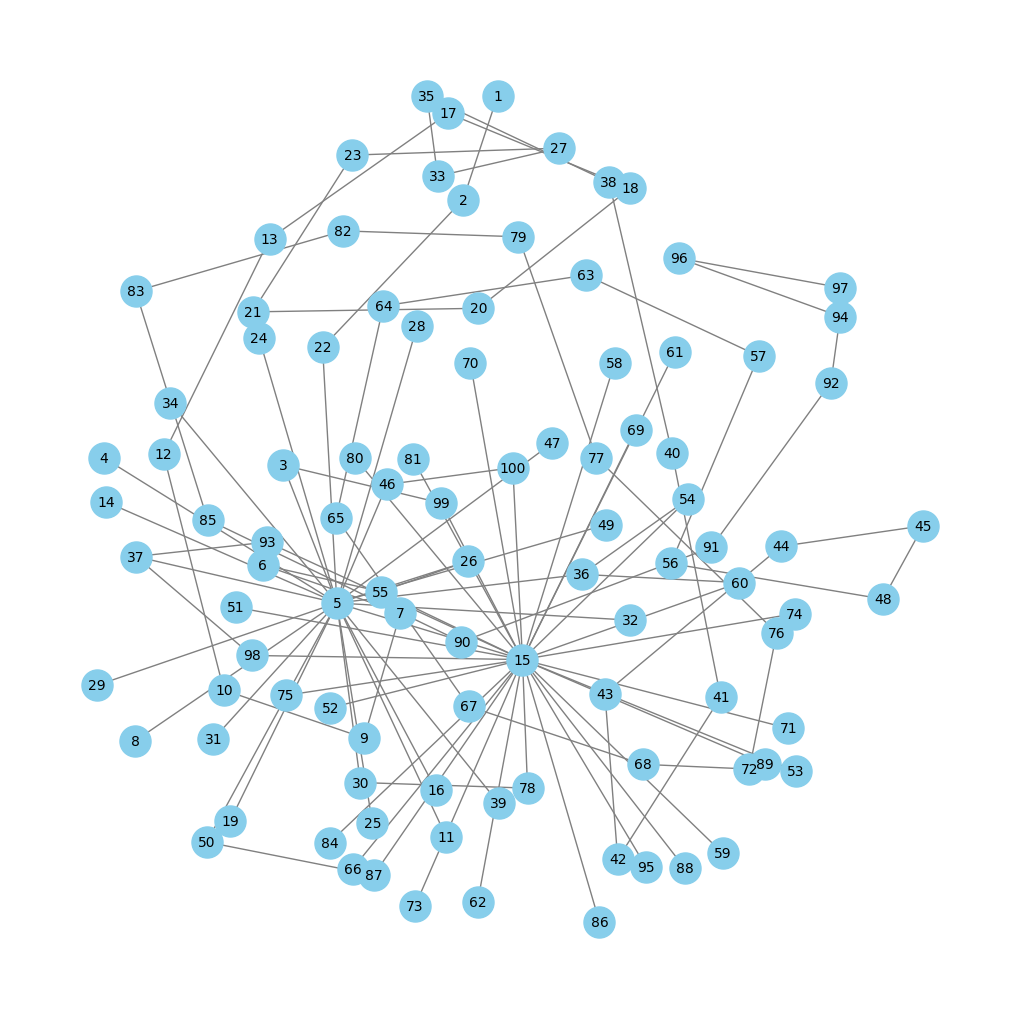

Top 5 Influential Nodes: [15, 5, 7, 6, 87]


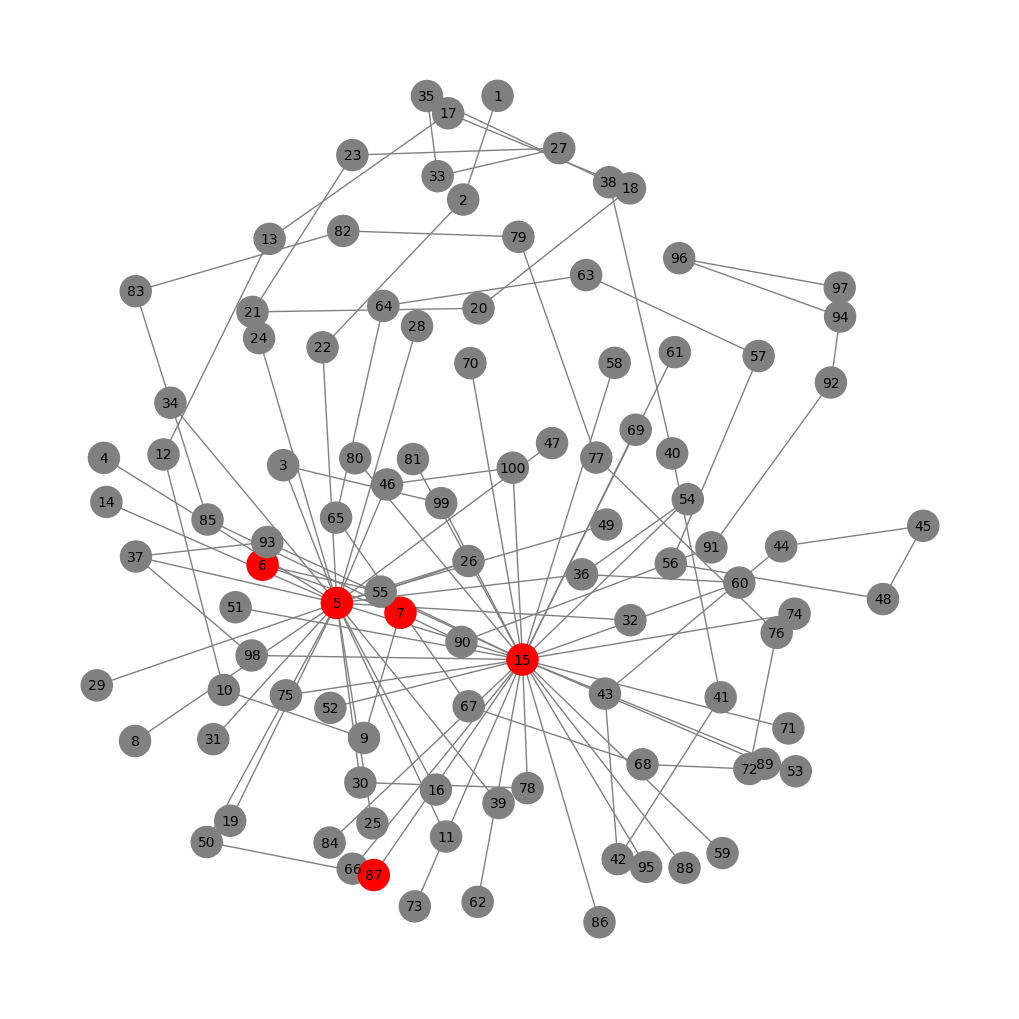

In [55]:
for i in range(10):
    G = create_connected_graph(num_nodes=100)
    node_colors = ['blue' if node <= 50 else 'green' for node in G.nodes]
    pos = nx.spring_layout(G, seed=42)  # Fix layout for consistency
    
    helper.display_graph(G)

    test_graph = G  # This is the graph created above

    node_features = {node: torch.rand(10) for node in G.nodes}

    top_nodes = get_most_influential_nodes(model, test_graph, node_features, top_k=5)
    print("Top 5 Influential Nodes:", top_nodes)

    outputGraph = helper.color_specific_nodes_red(test_graph, top_nodes)
    helper.display_colored_graph(outputGraph)
    
    plt.close()  # Close the plot to avoid overlapping figures

    # break